In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import model_from_json
from fbprophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from numpy import asarray
from numpy import save




warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 6]

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

The results for all models and datasets are available at http://jkuypers.pythonanywhere.com/

In [2]:

df1 = pd.read_csv('data1.csv', names=['data1'])
df2 = pd.read_csv('data2.csv', names=['data2'])
df3 = pd.read_csv('data3.csv', index_col='id')

In [3]:
def create_reverse_datetime(ordinal, end_date):
    '''Takes in an ordinal column - like an index - and converts it to a datetime column.
    It uses the last index of the ordinal column, sets it as the end_date, and creates a datetime column
    by iterating backwards over the ordinal column and converting each index into dates until it reaches
    the first index.
    Inputs:
    ordinal: ordered column (e.g id)
    end_date: string in format dd-mm-yyyy representing the desired last date of the dataset
    in format dd-mm-yyyy (e.g 15-11-2019)'''

    ordinal['timestamp'] = ordinal.index
    end_date = datetime.strptime(end_date, '%d-%m-%Y')
    end_date = end_date.date()
    for i in range(1, len(ordinal)):
        ordinal.loc[len(ordinal) - i, 'timestamp'] = end_date - timedelta(days=i)
        

    ordinal = ordinal.drop(ordinal.index[0])
    ordinal['timestamp'] = pd.to_datetime(ordinal['timestamp'])
    ordinal = ordinal.set_index('timestamp')
    ordinal.index = pd.to_datetime(ordinal.index)
    return ordinal

In [4]:
def plot_decomposition(ts, trend, seasonal, residual):
    """
    Plot time series data
    """
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

    ax1.plot(ts, label = 'Original')
    ax1.legend(loc = 'best')
    ax1.tick_params(axis = 'x', rotation = 45)

    ax2.plot(trend, label = 'Trend')
    ax2.legend(loc = 'best')
    ax2.tick_params(axis = 'x', rotation = 45)

    ax3.plot(seasonal,label = 'Seasonality')
    ax3.legend(loc = 'best')
    ax3.tick_params(axis = 'x', rotation = 45)

    ax4.plot(residual, label = 'Residuals')
    ax4.legend(loc = 'best')
    ax4.tick_params(axis = 'x', rotation = 45)
    plt.tight_layout()

    # Show graph
    plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts.name),
               x = 0.5,
               y = 1.05,
               fontsize = 18)
    plt.show()
    plt.close()

    return

def decompose_ts(ts, decomposition_frequency=365, plot=False):
    decomposition = seasonal_decompose(ts, freq=decomposition_frequency)
    decomposition_df = pd.DataFrame({'original': ts})

    decomposition_df.loc[:, 'trend'] = decomposition.trend
    decomposition_df.loc[:, 'seasonal'] = decomposition.seasonal
    decomposition_df.loc[:, 'residual'] = decomposition.resid

    if plot == True:
        plot_decomposition(ts=decomposition_df['original'],
                             trend=decomposition_df['trend'],
                             seasonal=decomposition_df['seasonal'],
                             residual=decomposition_df['residual'])
    return decomposition_df

# Dataset 1


Load dataset, set column name to 'data1, and create a synthetic datetime index which ends on Nov 15 2019

In [5]:
df1 = pd.read_csv('data1.csv', names=['data1'])
df1 = create_reverse_datetime(df1, end_date='15-11-2019')


Split the dataset into training (75%) and testing (25%) datasets. The analysis and models will be built on the training ('dataset') data.

Then decompose the time series to better understand it's trend and seasonality (if present)


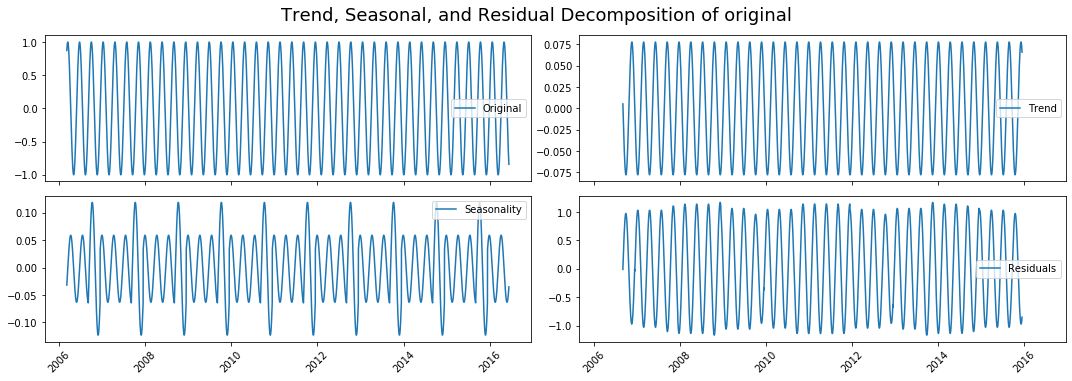

In [6]:
split_point = int(len(df1) * 0.75)
dataset, validation = df1[0:split_point], df1[split_point:]
decomposition_df = decompose_ts(dataset['data1'], plot=True)

Next, evaluate the stationarity of the dataset by combining the Augmented Dickey Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests


### ADF
Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary)

### KPSS

Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). For the air passenger data, the value of the test statistic is greater than the critical value at all confidence intervals, and hence we can say that the series is not stationary.

Let us understand the different types of stationarities and how to interpret the results of the above tests.

### Strict Stationary: 
A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions. 

### Trend Stationary: 
A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary. 

### Difference Stationary: 
A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test. It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

#### **Case 1:** 
Both tests conclude that the series is not stationary -> series is not stationary
#### **Case 2:** 
Both tests conclude that the series is stationary -> series is stationary
#### **Case 3:** 
KPSS = stationary and ADF = not stationary -> trend stationary, remove the trend to make series strict stationary
#### **Case 4:** 
KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [7]:
### STATIONARITY FUNCTION ###

def evaluate_stationarity(ts, rolling_window=365, name=None):
    '''performs Augmented Dickey Fuller (ADF) & Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests
    to evaluate the stationarity of the Time-Series, and makes general recommendations as to how to make
    the data stationary in case of non-stationarity'''
    # Determing rolling statistics
    rolmean = ts.rolling(window=rolling_window, center=False).mean()
    rolstd = ts.rolling(window=rolling_window, center=False).std()

    # Plot rolling statistics:
    orig = plt.plot(ts,
                    color='blue',
                    label=name)
    mean = plt.plot(rolmean,
                    color='red',
                    label='Rolling Mean')
    std = plt.plot(rolstd,
                   color='black',
                   label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for %s' % (name))
    plt.xticks(rotation=45)
    #plt.show(block=False)
    plt.close()
    ##ADF##
    ADF = adfuller(ts)
    ADF_df = pd.Series(ADF[:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
    for key, value in ADF[4].items():
        ADF_df['Critical Value (%s)' % key] = value
    print('Augmented Dickey-Fuller (ADF)')
    print('Null Hypothesis: The series has a unit root (is non-stationary)')
    print(ADF_df)

    if np.any(np.array([ADF_df['Critical Value (1%)'], ADF_df['Critical Value (5%)'], ADF_df['Critical Value (10%)']]) >
              ADF_df['Test Statistic']):
        print('[ADF] Reject null hypothesis - \n timeseries is stationary')
        ADF_ccl = 'stationary'
    elif ADF_df['Test Statistic'] < ADF_df['Critical Value (1%)']:
        print('[ADF] Reject null hypothesis - \n timeseries is stationary (99% confidence)')
        ADF_ccl = 'stationary'
    elif ADF_df['Test Statistic'] < ADF_df['Critical Value (5%)']:
        print('[ADF] Reject null hypothesis - \n timeseries is stationary (95% confidence)')
        ADF_ccl = 'stationary'
    elif ADF_df['Test Statistic'] < ADF_df['Critical Value (10%)']:
        print('[ADF] Reject null hypothesis - \n timeseries is stationary (90% confidence)')
        ADF_ccl = 'stationary'
    else:
        print('[ADF] Fail to reject the null hypothesis - \n time series is non-stationary')
        ADF_ccl = 'not stationary'

    ##KPSS##
    KPSS = kpss(ts, regression='c')
    KPSS_df = pd.Series(KPSS[0:3], index=['Test Statistic', 'p-value', '# Lags Used'])
    for key, value in KPSS[3].items():
        KPSS_df['Critical Value (%s)' % key] = value
    print()
    print('-------------------------------------------')
    print()
    print('Kwiatkowski–Phillips–Schmidt–Shin (KPSS)')
    print('Null Hypothesis: The process is trend stationary')
    print(KPSS_df)

    if np.any(np.array(
            [KPSS_df['Critical Value (1%)'], KPSS_df['Critical Value (5%)'], KPSS_df['Critical Value (10%)']]) >
              KPSS_df['Test Statistic']):
        print('[KPSS] Fail to reject null hypothesis - \n timeseries is stationary')
        KPSS_ccl = 'stationary'
    elif KPSS_df['Test Statistic'] < KPSS_df['Critical Value (1%)']:
        print('[KPSS] Fail to reject null hypothesis - \n timeseries is stationary (99% confidence)')
        KPSS_ccl = 'stationary'
    elif KPSS_df['Test Statistic'] < KPSS_df['Critical Value (2.5%)']:
        print('[KPSS] Fail to reject null hypothesis - \n timeseries is stationary (97.5% confidence)')
        KPSS_ccl = 'stationary'
    elif KPSS_df['Test Statistic'] < KPSS_df['Critical Value (5%)']:
        print('[KPSS] Fail to reject null hypothesis - \n timeseries is stationary (95% confidence)')
        KPSS_ccl = 'stationary'
    elif KPSS_df['Test Statistic'] < KPSS_df['Critical Value (10%)']:
        print('[KPSS] Fail to reject null hypothesis - \n timeseries is stationary (90% confidence)')
        KPSS_ccl = 'stationary'
    else:
        print('[KPSS] Reject the null hypothesis - \n time series is non-stationary')
        KPSS_ccl = 'not stationary'

    print()
    print('-------------------------------------------')
    print()
    print('Recommendation:')

    if ADF_ccl == 'stationary' and KPSS_ccl == 'stationary':
        print('ADF: stationary' + '    KPSS: stationary' + '\n time series is stationary')
        return 'stationary'

    elif ADF_ccl == 'not stationary' and KPSS_ccl == 'not stationary':
        print('ADF: not stationary' + '    KPSS: not stationary' +
              '\n time series is not stationary, use differencing and/or transformation(s)')
        return 'not stationary'

    elif ADF_ccl == 'stationary' and KPSS_ccl == 'not stationary':
        print('ADF: not stationary' + '    KPSS: not stationary' +
              '\n Difference stationary, use differencing to make timeseries stationary')
        return 'not stationary'

    elif ADF_ccl == 'not stationary' and KPSS_ccl == 'stationary':
        print('ADF: not stationary' + '    KPSS: not stationary' +
              '\n Trend stationary, remove trend to make timeseries strict stationary')
        return 'not stationary'

        

In [8]:
stationarity = evaluate_stationarity(dataset['data1'], name='data1')

Augmented Dickey-Fuller (ADF)
Null Hypothesis: The series has a unit root (is non-stationary)
Test Statistic                  -89.937971
p-value                           0.000000
# Lags Used                       4.000000
Number of Observations Used    3745.000000
Critical Value (1%)              -3.432097
Critical Value (5%)              -2.862312
Critical Value (10%)             -2.567181
dtype: float64
[ADF] Reject null hypothesis - 
 timeseries is stationary

-------------------------------------------

Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
Null Hypothesis: The process is trend stationary
Test Statistic            0.003565
p-value                   0.100000
# Lags Used              30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
[KPSS] Fail to reject null hypothesis - 
 timeseries is stationary

-------------------------------------------

Recommendation:
ADF: st

### The data is stationary, which means we can perform predictions on it.

## ARIMA

In [9]:
auto_arima(dataset['data1'], seasonal=True, m=7,max_p=5, max_d=5,max_q=5, max_P=5, max_D=5,max_Q=5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3750
Model:             SARIMAX(2, 0, 2)x(1, 1, 1, 7)   Log Likelihood                     nan
Date:                           Sun, 19 Jan 2020   AIC                                nan
Time:                                   20:35:54   BIC                                nan
Sample:                                        0   HQIC                               nan
                                          - 3750                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.736e-13      0.000  -2.31e-09      1.000      -0.000       0.000
ar.L1          1.9961      0.001   3673.548      0.000       1.995       1.997
ar.L2         -1.0000   6.71e-09  -1.49e+08      0.000      -1.000      -1.000
ma.L1               0   5.19e-09          0      1.000   -1.02e-08    1.02e-08
ma.L2              -0   1.03e-08         -0      1.000   -2.02e-08    2.02e-08
ar.S.L7             0   9.49e-10          0      1.000   -1.86e-09    1.86e-09
ma.S.L7             0   9.69e-09          0      1.000    -1.9e-08     1.9e-08
sigma2          1e-10   5.58e-11      1.791      0.073    -9.4e-12    2.09e-10
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):        1543456859.48
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                           -52.04
Prob(H) (two-sided):                  0.00   Kurtosis:                      3148.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.48e+26. Standard errors may be unstable.
"""

In [10]:
arima_model = SARIMAX(dataset['data1'], order = (2,0,2), seasonal_order = (1,1,1,7))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             data1   No. Observations:                 3750
Model:             SARIMAX(2, 0, 2)x(1, 1, 1, 7)   Log Likelihood                     nan
Date:                           Sun, 19 Jan 2020   AIC                                nan
Time:                                   20:35:55   BIC                                nan
Sample:                               03-08-2006   HQIC                               nan
                                    - 06-12-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9961      0.001   3163.120      0.000       1.995       1.997
ar.L2         -1.0000   7.78e-09  -1.29e+08      0.000      -1.000      -1.000
ma.L1               0   7.94e-06          0      1.000   -1.56e-05    1.56e-05
ma.L2              -0   1.58e-05         -0      1.000    -3.1e-05     3.1e-05
ar.S.L7             0    3.2e-08          0      1.000   -6.27e-08    6.27e-08
ma.S.L7             0   7.87e-06          0      1.000   -1.54e-05    1.54e-05
sigma2          1e-10   1.48e-09      0.068      0.946    -2.8e-09       3e-09
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):        1552893143.66
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                           -52.15
Prob(H) (two-sided):                  0.00   Kurtosis:                      3157.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+24. Standard errors may be unstable.
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMAResults
import pickle


# Serialize with Pickle
with open('arima_data1.pkl', 'wb') as pkl:
    pickle.dump(arima_result, pkl)
    
#code to load saved model
# with open('arima_data1.pkl', 'rb') as pkl:
#     sarimax1 = pickle.load(pkl)  #.predict(n_periods=5)

In [28]:
#make predictions
arima_pred = arima_result.predict(start = len(dataset), end = len(df1)-1, typ="levels").rename("ARIMA Predictions")
arima_pred.to_csv('arima_predictions_data1.csv', header=False)

In [30]:
#generate confidence intervals by using get_forecast(), save them to a dataframe
fcast = arima_result.get_forecast(len(validation))
fcast_df = fcast.conf_int()
fcast_df = fcast_df.rename(columns={'lower data1' : 'lower', 'upper data1': 'upper'})
fcast_df.to_csv('arima_conf_int_data1.csv')

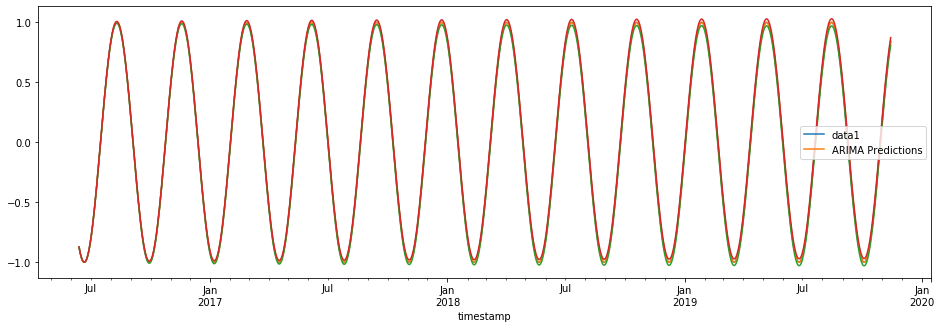

In [31]:
#plot the results
validation['data1'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);
fcast_df['lower'].plot()
fcast_df['upper'].plot()

In [32]:
arima_rmse_error = rmse(validation['data1'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df1['data1'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 3.161905273639541e-08
RMSE Error: 0.00017781747027892229
Mean: 7.143174940438257e-17


## LSTM

In [17]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def lstm_predictions(dataframe, save_model=False):
    # fix random seed for reproducibility
    np.random.seed(7)
    # load the dataset
    dataframe = dataframe.copy()  #read_csv('airline-passengers.csv', usecols=[1], engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.75)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
    if save_model == True:
    # serialize model to JSON
        model_json = model.to_json()
        with open("lstm_data.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("lstm_data.h5")
        print("Saved model to disk")
        
    return model


Epoch 1/10
 - 9s - loss: 0.0237
Epoch 2/10
 - 8s - loss: 5.8778e-04
Epoch 3/10
 - 9s - loss: 5.7938e-04
Epoch 4/10
 - 9s - loss: 5.7462e-04
Epoch 5/10
 - 9s - loss: 5.7609e-04
Epoch 6/10
 - 9s - loss: 5.6796e-04
Epoch 7/10
 - 9s - loss: 5.6665e-04
Epoch 8/10
 - 9s - loss: 5.6197e-04
Epoch 9/10
 - 9s - loss: 5.6442e-04
Epoch 10/10
 - 8s - loss: 5.5076e-04
Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


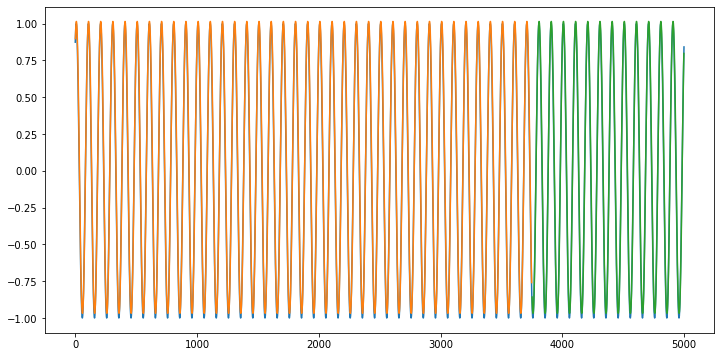

In [44]:
lstm_model = lstm_predictions(df1, save_model=False)

## Facebook Prophet

In [18]:

def prophet_predictions(dataframe, save_model=False):
    df_pr = dataframe.copy()
    df_pr = dataframe.reset_index()
    df_pr.columns = ['ds','y'] # To use prophet column names should be like that
    #note 'split_point' defined at beginning of jupyter notebook (=75%)
    train_pr, validation_pr = df_pr[0:split_point], df_pr[split_point:]
    
    
    m = Prophet()
    m.fit(train_pr)
    future = m.make_future_dataframe(periods=len(validation_pr),freq='D')
    prophet_pred = m.predict(future)
    prophet_pred.tail()
    
    
    prophet_pred_df = pd.DataFrame({"Date" : prophet_pred[split_point:]['ds'], "Pred" : prophet_pred[split_point:]["yhat"]})
    prophet_conf_int = pd.DataFrame({'lower': prophet_pred[split_point:]['yhat_lower'],
                                     'upper' : prophet_pred[split_point:]['yhat_upper']})
    prophet_pred_df = prophet_pred_df.set_index("Date")
    prophet_pred_df.index.freq = "D"
    prophet_conf_int.index.freq = "D"

    prophet_pred_df = prophet_pred_df.reset_index().drop({'Date'}, axis=1)

    validation["Prophet_Predictions"] = prophet_pred_df['Pred'].values
    import seaborn as sns
    plt.figure(figsize=(16,5))
    plt.plot(validation['data1'])
    plt.plot(validation['Prophet_Predictions'])
    plt.show()

    prophet_rmse_error = rmse(validation['data1'], validation["Prophet_Predictions"])
    prophet_mse_error = prophet_rmse_error**2
    mean_value = df1['data1'].mean()

    print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

    if save_model == True:
        with open("prophet_data1.pkl", "wb") as f:
            pickle.dump(m, f)
            
    return m

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


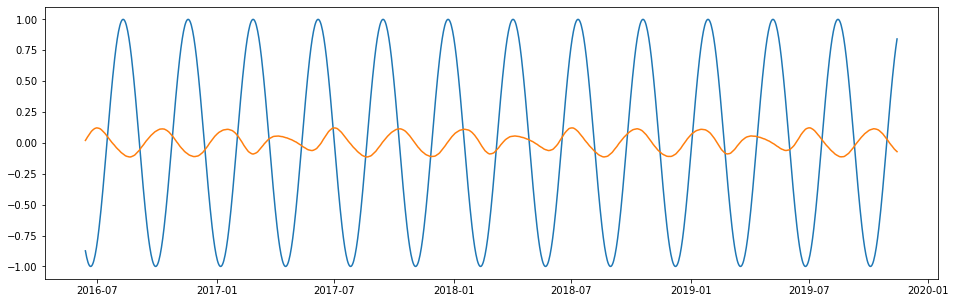

MSE Error: 0.5192159672504038
RMSE Error: 0.7205664211232742
Mean: 7.143174940438257e-17


In [50]:
prophet_model = prophet_predictions(df1)

# DATASET 2

**note** variables from df1 (data1.csv) analysis are going to be overridden (e.g split_point, dataset, validation

In [65]:
df2 = pd.read_csv('data2.csv', names=['data2'])
df2 = create_reverse_datetime(df2, end_date='15-11-2019')

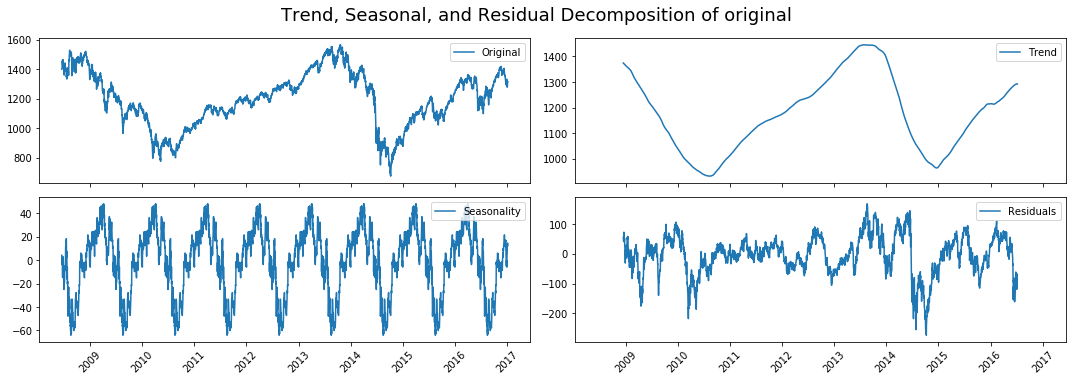

In [66]:
split_point = int(len(df2) * 0.75)
dataset, validation = df2[0:split_point], df2[split_point:]
decomposition_df = decompose_ts(dataset['data2'], plot=True)

In [67]:
stationarity = evaluate_stationarity(dataset['data2'], name='data2')

Augmented Dickey-Fuller (ADF)
Null Hypothesis: The series has a unit root (is non-stationary)
Test Statistic                   -2.054016
p-value                           0.263402
# Lags Used                      22.000000
Number of Observations Used    3104.000000
Critical Value (1%)              -3.432458
Critical Value (5%)              -2.862472
Critical Value (10%)             -2.567266
dtype: float64
[ADF] Fail to reject the null hypothesis - 
 time series is non-stationary

-------------------------------------------

Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
Null Hypothesis: The process is trend stationary
Test Statistic            0.626231
p-value                   0.020252
# Lags Used              29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
[KPSS] Fail to reject null hypothesis - 
 timeseries is stationary

-------------------------------------------

Recomm

**Dataset 2** is not stationary, we will need to apply differencing or transformation techniques to make it stationary & useable for our prediction models

In [19]:

def transformations(ts, decomposition_frequency=365):
    trans_df = pd.DataFrame()
    trans_df['original'] = ts
    
    original_stationarity = evaluate_stationarity(trans_df['original'], name='original')
    
    #differencing
    diff = ts - ts.shift(1)
    diff_stationarity = evaluate_stationarity(diff.dropna(), name='diff')
    if diff_stationarity == 'stationary':
        trans_df['diff'] = diff
    
    #log differencing
    ts_log = np.log(ts)
    log_diff = ts_log - ts_log.shift(1)
    log_diff_stationarity = evaluate_stationarity(log_diff.dropna(), name='log_diff')
    if log_diff_stationarity == 'stationary':
        trans_df['log_diff'] = log_diff
    
    #square root differencing
    ts_sqrt = np.sqrt(ts)
    sqrt_diff = ts_sqrt - ts_sqrt.shift(1)
    sqrt_diff_stationarity = evaluate_stationarity(sqrt_diff.dropna(), name='sqrt_diff')
    if sqrt_diff_stationarity == 'stationary':
        trans_df['sqrt_diff'] = sqrt_diff
        
    #decomposition
    decomposition = seasonal_decompose(ts, freq = decomposition_frequency)
    decomposition_df = pd.DataFrame({'original': ts})
    
    decomposition_df.loc[:,'trend'] = decomposition.trend
    decomposition_df.loc[:,'seasonal'] = decomposition.seasonal
    decomposition_df.loc[:,'residual'] = decomposition.resid

    plot_decomposition(ts = decomposition_df['original'], 
                       trend = decomposition_df['trend'],
                       seasonal = decomposition_df['seasonal'], 
                       residual = decomposition_df['residual'])
    
    residual_stationarity = evaluate_stationarity(decomposition.resid.dropna())
    if residual_stationarity == 'stationary':
        trans_df['residual'] = decomposition_df['residual']

    return trans_df

Augmented Dickey-Fuller (ADF)
Null Hypothesis: The series has a unit root (is non-stationary)
Test Statistic                    0.005676
p-value                           0.958999
# Lags Used                      18.000000
Number of Observations Used    4151.000000
Critical Value (1%)              -3.431926
Critical Value (5%)              -2.862237
Critical Value (10%)             -2.567141
dtype: float64
[ADF] Fail to reject the null hypothesis - 
 time series is non-stationary

-------------------------------------------

Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
Null Hypothesis: The process is trend stationary
Test Statistic            6.547891
p-value                   0.010000
# Lags Used              31.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
[KPSS] Reject the null hypothesis - 
 time series is non-stationary

-------------------------------------------

Recom

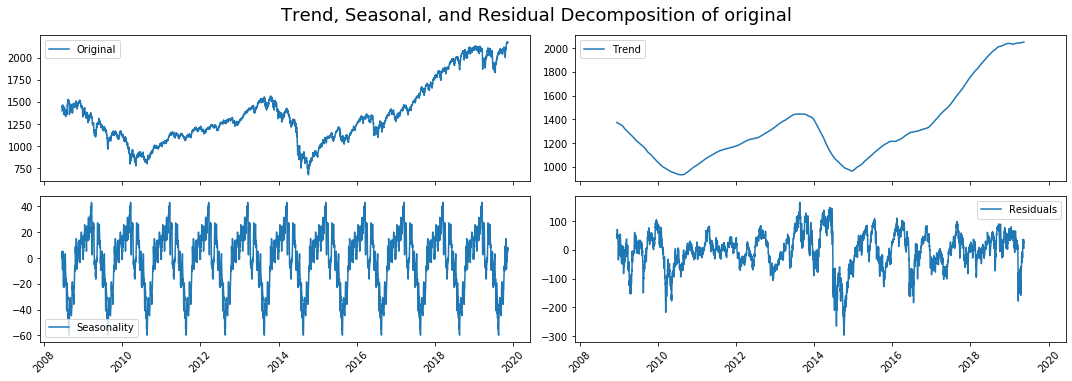

Augmented Dickey-Fuller (ADF)
Null Hypothesis: The series has a unit root (is non-stationary)
Test Statistic                -5.970090e+00
p-value                        1.945538e-07
# Lags Used                    1.800000e+01
Number of Observations Used    3.787000e+03
Critical Value (1%)           -3.432078e+00
Critical Value (5%)           -2.862304e+00
Critical Value (10%)          -2.567176e+00
dtype: float64
[ADF] Reject null hypothesis - 
 timeseries is stationary

-------------------------------------------

Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
Null Hypothesis: The process is trend stationary
Test Statistic            0.11834
p-value                   0.10000
# Lags Used              30.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64
[KPSS] Fail to reject null hypothesis - 
 timeseries is stationary

-------------------------------------------

Recommendation:
ADF: st

In [70]:
transformed_df2 = transformations(df2['data2'])

In [71]:
transformed_df2.head()

,original,diff,log_diff,sqrt_diff,residual
timestamp,,,,,
2008-06-15,1399.420044,NaN,NaN,NaN,NaN
2008-06-16,1402.109985,2.689941,0.001920,0.035936,NaN
2008-06-17,1403.449951,1.339966,0.000955,0.017888,NaN
2008-06-18,1441.469971,38.020020,0.026730,0.504048,NaN
2008-06-19,1457.599976,16.130005,0.011128,0.211832,NaN


After applying transformations, the dataset has been made stationary. Here, I will use the differenced time series to make predictions, but other transformed time series can be used

In [76]:
df2_diff = pd.DataFrame({'data2': transformed_df2['diff']})
df2_diff = df2_diff.dropna()
df2_diff.head()

,data2
timestamp,
2008-06-16,2.689941
2008-06-17,1.339966
2008-06-18,38.020020
2008-06-19,16.130005
2008-06-20,-19.039917


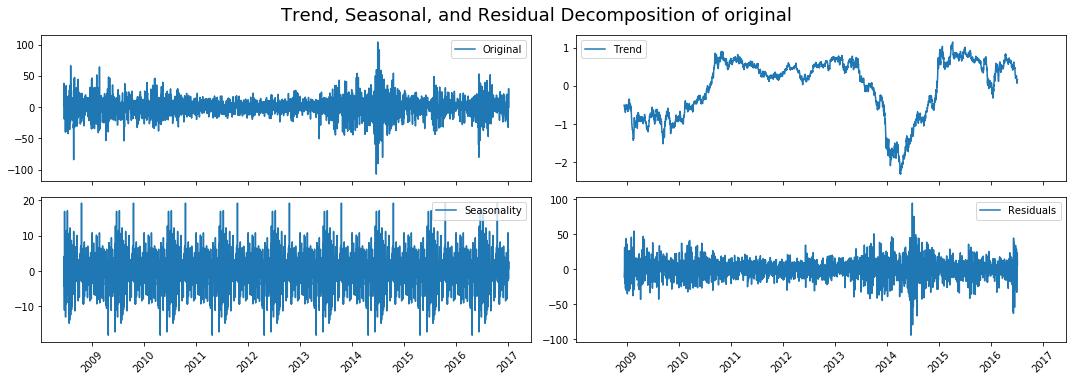

In [78]:
split_point = int(len(df2_diff) * 0.75)
dataset, validation = df2_diff[0:split_point], df2_diff[split_point:]
decomposition_df = decompose_ts(dataset['data2'], plot=True)

In [79]:
auto_arima(dataset['data2'], seasonal=True, m=7,max_p=5, max_d=5,max_q=5, max_P=5, max_D=5,max_Q=5).summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3126
Model:             SARIMAX(0, 0, 2)x(1, 0, 1, 7)   Log Likelihood              -12903.093
Date:                           Sun, 19 Jan 2020   AIC                          25818.187
Time:                                   18:47:33   BIC                          25854.472
Sample:                                        0   HQIC                         25831.211
                                          - 3126                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0066      0.053     -0.125      0.900      -0.110       0.096
ma.L1         -0.0879      0.013     -6.799      0.000      -0.113      -0.063
ma.L2         -0.0490      0.010     -4.714      0.000      -0.069      -0.029
ar.S.L7        0.7566      0.102      7.454      0.000       0.558       0.955
ma.S.L7       -0.7934      0.096     -8.266      0.000      -0.981      -0.605
sigma2       225.3150      3.382     66.621      0.000     218.686     231.944
===================================================================================
Ljung-Box (Q):                       90.36   Jarque-Bera (JB):              2513.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
arima_model = SARIMAX(dataset['data2'], order = (0,0,2), seasonal_order = (1,0,1,7))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             data2   No. Observations:                 3126
Model:             SARIMAX(0, 0, 2)x(1, 0, 1, 7)   Log Likelihood              -12903.103
Date:                           Sun, 19 Jan 2020   AIC                          25816.206
Time:                                   18:48:23   BIC                          25846.443
Sample:                               06-16-2008   HQIC                         25827.059
                                    - 01-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0878      0.013     -6.936      0.000      -0.113      -0.063
ma.L2         -0.0491      0.010     -4.813      0.000      -0.069      -0.029
ar.S.L7        0.7565      0.101      7.466      0.000       0.558       0.955
ma.S.L7       -0.7933      0.096     -8.293      0.000      -0.981      -0.606
sigma2       225.2974      3.279     68.719      0.000     218.872     231.723
===================================================================================
Ljung-Box (Q):                       90.35   Jarque-Bera (JB):              2512.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
# Serialize with Pickle
with open('arima_data2.pkl', 'wb') as pkl:
    pickle.dump(arima_result, pkl)

In [82]:
#make predictions
arima_pred = arima_result.predict(start = len(dataset), end = len(df2_diff)-1, typ="levels").rename("ARIMA Predictions") 
arima_pred.to_csv('arima_predictions_data2.csv', header=False)

In [83]:
#generate confidence intervals by using get_forecast(), save them to a dataframe
fcast = arima_result.get_forecast(len(validation))
fcast_df = fcast.conf_int()
fcast_df = fcast_df.rename(columns={'lower data2' : 'lower', 'upper data2': 'upper'})
fcast_df.to_csv('arima_conf_int_data2.csv')

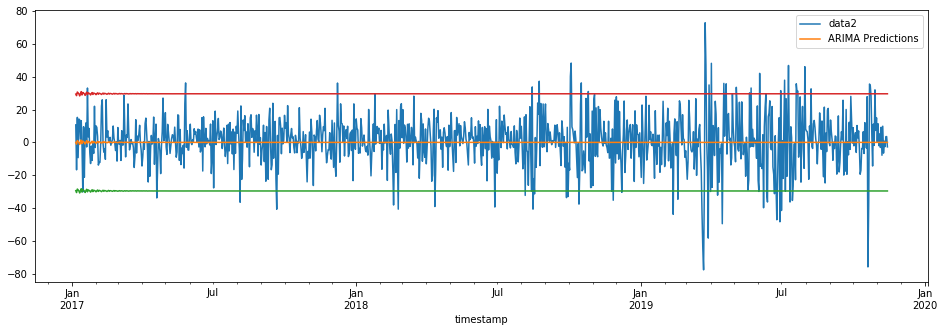

In [84]:
#plot the results
validation['data2'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);
fcast_df['lower'].plot()
fcast_df['upper'].plot()

In [85]:
arima_rmse_error = rmse(validation['data2'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df2['data2'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 238.21208791176127
RMSE Error: 15.434120898572788
Mean: 1355.7224626146262


Note that when differencing or applying transformations - the results need to be un-differenced (i.e you need to add the differenced lag to the prediction)

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

## LSTM

In [ ]:
lstm_model = lstm_predictions(df2, save_model=False)

## PROPHET

In [ ]:
prophet_model = prophet_predictions(df2, save_model=False)

# DATASET 3

In [38]:
df3 = pd.read_csv('data3.csv', index_col='id')
df3.head()

,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
id,,,,,,,,,,,,,,,,,,,,,
1,1,128.596,11.316404,5.95,26.031126,0,1.731,120000,2,127.561201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,126.673,8.763446,5.95,26.016697,0,30.518,85000,4,126.323528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,126.880,6.499730,5.95,26.008760,0,4.424,4200000,3,126.761433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,126.362,0.865854,5.95,26.008619,0,43.059,5000001,2,127.025765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,124.918,11.938543,5.95,25.981840,0,6.332,10000,2,125.736081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df3.columns

Index(['bond_id', 'trade_price', 'weight', 'current_coupon',
       'time_to_maturity', 'is_callable', 'reporting_delay', 'trade_size',
       'trade_type', 'curve_based_price', 'received_time_diff_last1',
       'trade_price_last1', 'trade_size_last1', 'trade_type_last1',
       'curve_based_price_last1', 'received_time_diff_last2',
       'trade_price_last2', 'trade_size_last2', 'trade_type_last2',
       'curve_based_price_last2', 'received_time_diff_last3',
       'trade_price_last3', 'trade_size_last3', 'trade_type_last3',
       'curve_based_price_last3', 'received_time_diff_last4',
       'trade_price_last4', 'trade_size_last4', 'trade_type_last4',
       'curve_based_price_last4', 'received_time_diff_last5',
       'trade_price_last5', 'trade_size_last5', 'trade_type_last5',
       'curve_based_price_last5', 'received_time_diff_last6',
       'trade_price_last6', 'trade_size_last6', 'trade_type_last6',
       'curve_based_price_last6', 'received_time_diff_last7',
       'trade_

In [22]:
#count number of rows with null values
df3.isnull().sum()

bond_id                          0
trade_price                      0
weight                           0
current_coupon                   0
time_to_maturity                 0
is_callable                      0
reporting_delay                  0
trade_size                       0
trade_type                       0
curve_based_price                0
received_time_diff_last1         0
trade_price_last1                0
trade_size_last1                 0
trade_type_last1                 0
curve_based_price_last1         39
received_time_diff_last2      2000
trade_price_last2             2000
trade_size_last2              2000
trade_type_last2              2000
curve_based_price_last2       2076
received_time_diff_last3      3970
trade_price_last3             3970
trade_size_last3              3970
trade_type_last3              3970
curve_based_price_last3       4082
received_time_diff_last4      5922
trade_price_last4             5922
trade_size_last4              5922
trade_type_last4    

First, I am going to try to salvage rows with NaN, even though they do not represent alot of rows. I will drop the rows with more than 60% of values missing

In [23]:
def drop_nan_rows(df, percent_treshold=0.6):
    treshold = len(df.columns) * percent_treshold
    too_many_nan = df.isnull().sum(axis=1).where(df.isnull().sum(axis=1) > treshold)
    too_many_nan.dropna(inplace=True)
    df.drop(too_many_nan.index, inplace=True)
    return df

In [24]:
len(df3)

762678

In [25]:
df3 = drop_nan_rows(df3, percent_treshold=0.6)
len(df3)

758707

Another method I tested to plug missing values is this following 'ARIMA_plug' function, which tries to predict the missing values. While it works, it is very computer intensive. Also, it might not be reliable to make predictions with only 5-9 datapoints. Exponential smoothing could also be used here instead of ARIMA.

**This method was not used in the end.**

In [26]:
sample_study = df3.sample(300)

##NEW VERSION##
def trade_type_dict_(df):
    trade_type_dict = {}

    for column in df3.filter(regex=('trade_type*')):
        trade_type_dict[column] = 0
        
    df = df.fillna(trade_type_dict)

    for key, value in trade_type_dict.items():
        df[key] = df[key].astype('int64')
        
    return df, trade_type_dict
    
def drop_nan_rows(df, percent_treshold=0.6):
    treshold = len(df.columns) * percent_treshold
    df = df.dropna(axis=0, thresh=treshold).reset_index()
    return df
    
def fill_missing(df):
    #first drop all rows that have over 60% of columns with missing values
    df = drop_nan_rows(df)
    df, trade_type_dict = trade_type_dict_(df)
    for idx, row in df.iterrows():
        if row.isnull().any():
            row['missing_values'] = int(1)
            
            ##CATEGORICAL VARIABLES##
            #Trade type
            trade_type_cols = row[list(trade_type_dict.keys())]
            trade_types_list = [x for x in trade_type_cols.values if x > 0] #all NaNs for trade type were set 
                                                                            #to 0 previously - so excluded all NaN to 
                                                                            #replace w/ mode later
            try:
                trade_types_mode = statistics.mode(trade_types_list)

            except statistics.StatisticsError:
                #temporary solution: if multi-modal - only look at the most recent activity (i.e first half of the list)
                #and get the mode for the most recent activity
                try:
                    trade_types_mode = statistics.mode(trade_types_list[:int(len(trade_types_list)/2)])
                except statistics.StatisticsError:
                    #sets most recent as mode
                    trade_types_mode = statistics.mode(trade_types_list[0:1])
                
            new_trade_types_list = trade_type_cols.values.tolist()
            
            new_trade_types_list = [trade_types_mode if x == 0.0 else x for x in new_trade_types_list]
            
            for idx_type, type_column in enumerate(df.filter(regex=('trade_type*'))):
                df.loc[idx, type_column] = new_trade_types_list[idx_type]
                                
            ##CONTINUOUS VARIABLES##
            
            #Curved based price
            curve_based_price = row.where(row.index.str.contains('curve_based_price', regex=False) == True).dropna()
            len_curve_price = len(curve_based_price)
           # predicted_values = smooth(np.asarray(curve_based_price))
            predicted_values_CBP = ARIMA_plug_NaN(curve_based_price, train_length=len_curve_price) #there are 11 curve_based_price columns

            for idx_cbp, curve_column in enumerate(df.filter(regex=('curve_based_price*'))):
                df.loc[idx, curve_column] = predicted_values_CBP[idx_cbp]

            #trade price
            trade_price = row.where(row.index.str.contains('trade_price', regex=False) == True).dropna()
            len_price = len(trade_price)
           # predicted_values = smooth(np.asarray(curve_based_price))
            predicted_values_price = ARIMA_plug_NaN(trade_price, train_length=len_price) #there are 11 curve_based_price columns

            for idx_p, price_column in enumerate(df.filter(regex=('trade_price*'))):
                df.loc[idx, price_column] = predicted_values_price[idx_p]

            #received time diff
            received_time_diff = row.where(row.index.str.contains('received_time_diff', regex=False) == True).dropna()
            len_TD = len(received_time_diff)
           # predicted_values = smooth(np.asarray(curve_based_price))
            predicted_values_TimeDiff = ARIMA_plug_NaN(received_time_diff, train_length=len_TD) #there are 11 curve_based_price columns

            for idx_TD, TimeDiff_column in enumerate(df.filter(regex=('received_time_diff*'))):
                df.loc[idx, TimeDiff_column] = predicted_values_TimeDiff[idx_TD]

            #trade size
            trade_size = row.where(row.index.str.contains('trade_size', regex=False) == True).dropna()
            len_TS = len(trade_size)
           # predicted_values = smooth(np.asarray(curve_based_price))
            predicted_values_TradeSize = ARIMA_plug_NaN(trade_size, train_length=len_TS) #there are 11 curve_based_price columns
            #round to nearest 1000 to maintain consistent data format
            predicted_values_TradeSize = [round(x, -3) for x in predicted_values_TradeSize]

            for idx_TS, TradeSize_column in enumerate(df.filter(regex=('trade_size*'))):
                df.loc[idx, TradeSize_column] = predicted_values_TradeSize[idx_TS]
        else:
            row['missing_values'] = int(0)
    return df


I reduced the size of the dataset to the first 80,000 entries to make computation faster

In [40]:
df3 = df3[0:80000] #normally 80,000 but here only use 10,000 so computations go faster
df3 = df3.dropna()


80000

Three new columns are built; 'trade_type_mode' which holds the most commonly traded mode for that row, 'trade_price_forecast' and
'curve_price_forecast', which correspond to 1 lag exponential smoothing forecasts using the respective columns (i.e 'trade_price_last*' and 'curve_based_price_last*'. Note that for the
trade type mode, if the row was mutlimodal, a new mode was calculated using the most recent trade type

In [31]:
df3['trade_type_mode'] = df3.filter(regex=("trade_type*")).mode(axis=1)[0]

In [32]:
trade_price_df = df3.filter(regex=("trade_price_last*"))
trade_price_df = trade_price_df.iloc[:, ::-1]
trade_price_df['list'] = trade_price_df.values.tolist()

curve_price_df = df3.filter(regex=("curve_based_price_last*"))
curve_price_df = curve_price_df.iloc[:, ::-1]
curve_price_df['list'] = curve_price_df.values.tolist()

In [33]:
# !!VERY SLOW!!
trade_price_df['trade_price_forecast'] = trade_price_df['list'].apply(lambda x: ExponentialSmoothing(x, trend='add').fit().forecast(1)) 
curve_price_df['curve_price_forecast'] = curve_price_df['list'].apply(lambda x: ExponentialSmoothing(x, trend='add').fit().forecast(1)) 


In [34]:
#merging all the dataframes into one
mergedDf = df3.merge(curve_price_df, left_index=True, right_index=True)

mergedDf_ = mergedDf.merge(trade_price_df, left_index=True, right_index=True)
mergedDf_ = mergedDf_.loc[:,~mergedDf_.columns.duplicated()]

mergedDf_.drop(list(mergedDf_.filter(regex='_y$')), axis=1, inplace=True)
# mergedDf_.drop(list(mergedDf_.filter(regex='_x$')), axis=1, inplace=True) #use one or the other
mergedDf_.columns = mergedDf_.columns.str.rstrip('_x')  # strip suffix at the right end only.

mergedDf_= mergedDf_.drop('list', axis=1)
# mergedDf_= mergedDf_.drop(['time_diff_ExpSm','list','curve_price_ExpSm',
#                           'trade_price_ExpSm'] , axis=1)

mergedDf_.columns

Index(['bond_id', 'trade_price', 'weight', 'current_coupon',
       'time_to_maturity', 'is_callable', 'reporting_delay', 'trade_size',
       'trade_type', 'curve_based_price', 'received_time_diff_last1',
       'trade_price_last1', 'trade_size_last1', 'trade_type_last1',
       'curve_based_price_last1', 'received_time_diff_last2',
       'trade_price_last2', 'trade_size_last2', 'trade_type_last2',
       'curve_based_price_last2', 'received_time_diff_last3',
       'trade_price_last3', 'trade_size_last3', 'trade_type_last3',
       'curve_based_price_last3', 'received_time_diff_last4',
       'trade_price_last4', 'trade_size_last4', 'trade_type_last4',
       'curve_based_price_last4', 'received_time_diff_last5',
       'trade_price_last5', 'trade_size_last5', 'trade_type_last5',
       'curve_based_price_last5', 'received_time_diff_last6',
       'trade_price_last6', 'trade_size_last6', 'trade_type_last6',
       'curve_based_price_last6', 'received_time_diff_last7',
       'trade_

In [35]:
#unpack values saved as list
mergedDf_['trade_price_forecast'] = mergedDf_['trade_price_forecast'].apply(pd.Series)

mergedDf_['curve_price_forecast'] = mergedDf_['curve_price_forecast'].apply(pd.Series)

Below I define two feature selection functions, Select_K_Best which builds a number regression models with different features of the dataset to evaluate the contribution of each column towards the improvement of the model. It then returns a new dataset with the most important features. The 'trade_price_last*' features are the most important.

In [36]:
from sklearn.feature_selection import SelectKBest, f_regression

def select_KBest(df, col_names, train, test, target='Response', score_func=f_regression, k = 12):
    '''
    Prints ranked pvalues and scores of all features and returns a dataframe with only those selected features
    and the target feature. n.b: maintains the index of all rows throughout so the target feature is in the right place
    when added at the end.

    For more info on sklearn.selectKBest and parameters, visit - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest
    :param score_func: function used to calculate score and p-value, default is 'chi2'
    can be: 'chi2', 'f_classif', 'f_regression', 'mutual_info_regression' - more can be added but need to be imported
    :param k: number of features to select
    :param X: features
    :param y: target
    :return: dataframe with selected features and target
    '''
    feat_selector = SelectKBest(score_func=score_func, k=k) 
    selector = feat_selector.fit(train, test)

    feat_scores = pd.DataFrame()
    feat_scores["Score"] = np.round(selector.scores_,2)
    feat_scores["Pvalue"] = selector.pvalues_
    feat_scores["Support"] = selector.get_support()
    feat_scores["Attribute"] = col_names

    feat_scores = feat_scores.sort_values('Score', ascending=False, axis=0)
    # print(sorted_df)
    feat_scores = feat_scores.iloc[:k, :]  # get selected number of rows from ranking
    sorted_columns = feat_scores['Attribute'].values  # get column names

    print("Ranked input features:\n", feat_scores)

    new_df = df[sorted_columns] #create new DF with selected rows - created in def __init__()
    new_df[target] = df[target].values # add 'Response' column to new dataframe
    print("New DataFrame Columns:\n", new_df.columns)
    print('Length of new_df: \n', len(new_df))
    print(new_df.dtypes)

    x_train = train[sorted_columns]
    x_test = test[sorted_columns]

    print("New x_train Columns:\n", x_train.columns)
    print("New x_test Columns:\n", x_train.columns)

    print('Length of x_train: \n', len(x_train))
    print('Length of x_test: \n', len(x_test))
    
    return new_df


In [ ]:
X = mergedDf_.drop('trade_price', axis=1)
y = mergedDf_['trade_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

I use select k . best to return a new dataframe with the best features

In [ ]:
new_df3_best = select_KBest(mergedDf_, X_train.columns, X_train, y_train, target='trade_price', score_func=f_regression, k = 23)
    
    

Ranked input features:
          Score  Pvalue  Support                 Attribute
10  1456316.89     0.0     True         trade_price_last1
8   1423440.96     0.0     True         curve_based_price
13  1355307.81     0.0     True   curve_based_price_last1
18  1318332.52     0.0     True   curve_based_price_last2
60  1299184.88     0.0     True      curve_price_forecast
23  1281898.07     0.0     True   curve_based_price_last3
28  1237743.50     0.0     True   curve_based_price_last4
33  1200447.99     0.0     True   curve_based_price_last5
38  1166602.88     0.0     True   curve_based_price_last6
15  1151806.07     0.0     True         trade_price_last2
43  1136091.57     0.0     True   curve_based_price_last7
48  1106878.36     0.0     True   curve_based_price_last8
53  1071132.70     0.0     True   curve_based_price_last9
20  1068573.68     0.0     True         trade_price_last3
58  1042539.20     0.0     True  curve_based_price_last10
25   989832.09     0.0     True         trade_pr

In [ ]:
new_df3_best = new_df3_best.loc[:,~new_df3_best.columns.duplicated()]

In [ ]:
new_df3_best.columns

Index(['trade_price_last1', 'curve_based_price', 'curve_based_price_last1',
       'curve_based_price_last2', 'curve_price_forecast',
       'curve_based_price_last3', 'curve_based_price_last4',
       'curve_based_price_last5', 'curve_based_price_last6',
       'trade_price_last2', 'curve_based_price_last7',
       'curve_based_price_last8', 'curve_based_price_last9',
       'trade_price_last3', 'curve_based_price_last10', 'trade_price_last4',
       'trade_price_last5', 'trade_price_last6', 'trade_price_last7',
       'trade_price_last8', 'trade_price_last9', 'trade_price_last10',
       'trade_price_forecast', 'trade_price'],
      dtype='object')

In [ ]:
new_df3_best.head()

,trade_price_last1,curve_based_price,curve_based_price_last1,curve_based_price_last2,curve_price_forecast,curve_based_price_last3,curve_based_price_last4,curve_based_price_last5,curve_based_price_last6,trade_price_last2,...,curve_based_price_last10,trade_price_last4,trade_price_last5,trade_price_last6,trade_price_last7,trade_price_last8,trade_price_last9,trade_price_last10,trade_price_forecast,trade_price
id,,,,,,,,,,,,,,,,,,,,,
10,125.10100,126.017363,124.717608,124.721953,124.120964,126.180334,126.636079,125.736081,127.025765,124.75700,...,129.435587,128.891,124.918,126.362,126.880,126.673,128.596,129.089,126.860359,126.26800
11,126.26800,128.262332,126.017363,124.717608,124.962997,124.721953,126.180334,126.636079,125.736081,125.10100,...,127.561201,126.061,128.891,124.918,126.362,126.880,126.673,128.596,125.465195,128.39900
12,128.39900,127.833688,128.262332,126.017363,128.477755,124.717608,124.721953,126.180334,126.636079,126.26800,...,126.323528,124.757,126.061,128.891,124.918,126.362,126.880,126.673,126.446654,130.51939
13,130.51939,125.490402,127.833688,128.262332,127.952827,126.017363,124.717608,124.721953,126.180334,128.39900,...,126.761433,125.101,124.757,126.061,128.891,124.918,126.362,126.880,128.185196,131.47109
14,131.47109,127.637634,125.490402,127.833688,125.490402,128.262332,126.017363,124.717608,124.721953,130.51939,...,127.025765,126.268,125.101,124.757,126.061,128.891,124.918,126.362,131.834604,131.14667


At this point, a new strategy was implemented, one where the dataset's **'trade_price_last*'** values for each row are transformed into a univariate timeseries by means of interpolation, using the 'time_diff' features to create equally distanced interpolation points.

This means that all the other features are ignored, and only the trade price time series is used. Note that the target trade price is then added at the end of the interpolated time series.
    
The issue with this method is that a new model would need to be trained for each newly created trade_price timeseries, meaning
that 2,288,034 models would need to be trained (762,678 timeseries * 3 models). Instead, 10,000 trade price time series were averaged into one
training time series, which was then used to train and fit all the models, resulting in only 3 models needing to be being trained. A new test set of 500 trade price series
is then built (excluding any of the 10,000 used to build the averaged trade price time series), and each model is evaluated on these sample
time series. Note that clicking 'analyse' for Dataset 3 will always return the plot for the averaged interpolation, aswell as a plot for a sample interpolation
            

In [3]:
#CUBIC INTERPOLATION TO CREATE EVENLY SPACED TS

import numpy as np
from scipy.interpolate import spline, UnivariateSpline
import matplotlib.pyplot as plt
def cubic_interp(x_, y_, plot=False):
    '''
    x_ = time difference array
    y_ = y value (e.g trade price) array
    returns evenly spaced x with corresponding interpolated y values'''
    x_data = np.array(x_)

    y_data = np.array(y_)

    x_data_smooth = np.linspace(min(x_data), max(x_data), 1000) #steps of 3600 represents hourly data (assuming initial data is in seconds)

    spl = UnivariateSpline(x_data, y_data, s=10, k=2)
    y_data_smooth = spl(x_data_smooth)
    if plot == True:
        fig, ax = plt.subplots(1,1)
        ax.plot(x_data_smooth, y_data_smooth, 'b')
        ax.plot(x_data_smooth, y_data_smooth, 'b')

        ax.scatter(x_data_smooth, y_data_smooth)
        ax.scatter(x_data, y_data)

        plt.show()
    return x_data_smooth, y_data_smooth

In [4]:
def apply_cubic(row):

    x_data = row.filter(regex=("received_time_diff_last*"))
    #add incrementing noise to time values so there are no equal values (CubicInterp need STRICTLY increasing x values)   
    for i in range(len(x_data)):
        x_data[i] = x_data[i] + i/2
                          
    y_data = row.filter(regex=("trade_price_last*"))
    
    x_smooth, y_smooth = cubic_interp(x_data, y_data)
    
    x_df = pd.DataFrame({'time': x_smooth})
    x_df['trade_price'] = y_smooth

    return x_df


In [24]:
def create_reverse_datetime(ordinal, end_date):

    ordinal['timestamp'] = ordinal.index

    end_date = datetime.strptime(end_date, '%d-%m-%Y')
    end_date = end_date.date()
    for i in range(1, len(ordinal)):
        ordinal.loc[len(ordinal) - i, 'timestamp'] = end_date - timedelta(days=i)
    ordinal = ordinal.drop(ordinal.index[0])
    ordinal['timestamp'] = pd.to_datetime(ordinal['timestamp'])


    ordinal = ordinal.set_index('timestamp')
    ordinal.index = pd.to_datetime(ordinal.index)
    return ordinal

def apply_df_cubic(df, nbr_cols):
    '''Apply cubic interpolation to a dataframe to create interpolated univariate time series.
    Used in "create_interpolation_df"'''
    df_dict = {}
    for i in range(nbr_cols):
        row = df.iloc[i]
        x_data = row.filter(regex=("received_time_diff_last*"))
        #add incrementing noise to time values so there are no equal values 
        # (CubicInterp need STRICTLY increasing x values)   
        for u in range(len(x_data)):
            x_data[u] = x_data[u] + u/2

        y_data = row.filter(regex=("trade_price_last*"))

        x_smooth, y_smooth = cubic_interp(x_data, y_data, plot=False)

        df_dict.update({'ts_%s'%i : y_smooth})

    new_df = pd.DataFrame.from_dict(df_dict)
    
    #inverse df
    new_df_ = new_df[::-1]
    
    #create mean columns
    new_df_['mean'] = new_df_.mean(axis=1)
    
    mean_df = new_df_['mean'].reset_index()#.drop('index', axis=1)
    mean_df = mean_df.drop('index', axis=1)
    
    #create timestamp as index
    mean_ts = create_reverse_datetime(mean_df, end_date='15-11-2019')
    
    
#     #append target trade_price - use for prediction
#     df['trade_price'] 
#     interp_df_ = interp_df_.append({'trade_price': target_price}, ignore_index=True)
    return mean_ts

First I create a training timeseries, which is the average of 10,000 interpolations on the trade_price columns.
After training all the models on this averaged interpolation, I will create a dataframe with 500 sample interpolations that will be used to evaluate the performance of the models trained on the averaged interpolation

In [11]:
big_sample = df3.sample(10000)
interp_df = apply_df_cubic(big_sample, nbr_cols=len(big_sample)) #creates averaged time series for 10,000 interpolations
interp_df.head()

Now that the training time series is built, it is time to build a dataframe where each column represents a testing time series that will be used to evaluate the accuracy of the trained prediction models

All the results are available in the app and will not be saved during when run in jupyter

In [ ]:
def transform_df(df, nbr_cols): #nbr_cols = number of training instances
    df_dict = {}
    for i in range(nbr_cols):
        row = df.iloc[i]
        x_data = row.filter(regex=("received_time_diff_last*"))
        #add incrementing noise to time values so there are no equal values (CubicInterp need STRICTLY increasing x values)   
        for u in range(len(x_data)):
            x_data[u] = x_data[u] + u/2

        y_data = row.filter(regex=("trade_price_last*"))

        x_smooth, y_smooth = cubic_interp(x_data, y_data)
        
        #append target value - trade_price - will be last value when inverted
        target = row['trade_price']

        y_smooth = np.insert(y_smooth, 0, target, axis=0)

        df_dict.update({'ts_%s'%i : y_smooth})

    new_df = pd.DataFrame.from_dict(df_dict)
    
    #inverse df
    new_df_ = new_df[::-1]
   
    new_df_ = new_df_.reset_index()#.drop('index', axis=1)
    new_df_ = new_df_.drop('index', axis=1)
    
    #create timestamp as index
    
    new_df_['timestamp'] = new_df_.index

    end_date = datetime.strptime('15-11-2019', '%d-%m-%Y')
    end_date = end_date.date()
    for i in range(1, len(new_df_)):
        new_df_.loc[len(new_df_) - i, 'timestamp'] = end_date - timedelta(days=i)
    new_df_ = new_df_.drop(new_df_.index[0])
    new_df_['timestamp'] = pd.to_datetime(new_df_['timestamp'])

    new_df_ = new_df_.set_index('timestamp')
    new_df_.index = pd.to_datetime(new_df_.index)
    
    return new_df_

In [ ]:
test_df = df3.sample(100) #number of testing time series usually 500
test_df = test_df.reset_index().drop('index', axis=1)

In [ ]:
Transtest_df = transform_df(test_df, nbr_cols=len(test_df))
Transtest_df.head()

## ARIMA

### training

In [ ]:
split_point = int(len(interp_df) * 0.75)
dataset, validation = interp_df[0:split_point], interp_df[split_point:]

In [ ]:
auto_arima(dataset['mean'], seasonal=True, m=7,max_p=5, max_d=5,max_q=5, max_P=5, max_D=5,max_Q=5).summary()

In [ ]:
arima_model = SARIMAX(dataset['mean'], order = (2,0,2), seasonal_order = (1,1,1,7))
arima_result = arima_model.fit()
arima_result.summary()

In [ ]:
from statsmodels.tsa.arima_model import ARIMAResults
import pickle


# Serialize with Pickle
with open('arima_data3.pkl', 'wb') as pkl:
    pickle.dump(arima_result, pkl)

In [ ]:
#make predictions
arima_pred = arima_result.predict(start = len(dataset), end = len(df1)-1, typ="levels").rename("ARIMA Predictions")
arima_pred.to_csv('arima_predictions_data3.csv', header=False)

In [ ]:
#generate confidence intervals by using get_forecast(), save them to a dataframe
fcast = arima_result.get_forecast(len(validation))
fcast_df = fcast.conf_int()
fcast_df = fcast_df.rename(columns={'lower mean' : 'lower', 'upper mean': 'upper'})
fcast_df.to_csv('arima_conf_int_data3.csv')

In [ ]:
#plot the results
validation['mean'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);
fcast_df['lower'].plot()
fcast_df['upper'].plot()

### testing

In [ ]:
arima_dict = {}
for column in TestInterpDF.columns:
    df = TestInterpDF[column]
    split_point_ = int(len(df) * 0.75)
    train_, validation_ = df[0:split_point_], df[split_point_:]

    arima_pred = arima_result.predict(start = len(train_), end = len(df)-1, typ="levels").rename("Pred")
    fcast = arima_result.get_forecast(len(validation_))

    pred_df = pd.DataFrame(arima_pred)
    confInt_df = pd.DataFrame(fcast.conf_int())
    # define data
    data = pred_df #asarray(arima_pred)
    data_ = df #asarray(df.values)
    upper = confInt_df['upper %s'%column]  #asarray(fcast.conf_int()['upper data3'])
    lower = confInt_df['lower %s'%column]  #asarray(fcast.conf_int()['lower data3'])

    # save to npy file
    save('arima_TestPred_%s.npy'%column, data)
    save('arima_Orig_%s.npy'%column, data_)
        # save to npy file
    save('arima_Upper_%s.npy'%column, upper)
    save('arima_Lower_%s.npy'%column, lower)
    
    #get error
    arima_rmse_error = rmse(validation_, arima_pred)
    arima_mse_error = arima_rmse_error**2
    mean_value = df3['data3'].mean()
    arima_dict.update({'%s'%column : {'RMSE' : np.round(arima_rmse_error, 2), 'MSE': np.round(arima_mse_error,2),
                                     'Mean': mean_value}})

arima_df = pd.DataFrame(arima_dict)
arima_df.to_csv('arima_sample_predictions.csv')

## LSTM

#### training

In [ ]:
lstm_model_average = lstm_predictions(interp_df, save=False)

#### testing

In [ ]:
# LSTM for international airline passengers problem with regression framing

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
ll_scores = list()
look_back =1

lstm_dict = {}
for column in TestTranstest_df.columns:
    predict = TestTranstest_df[column].values.reshape(-1, 1)
    # fix random seed for reproducibility
    numpy.random.seed(7)
    # load the dataset
    dataset = predict
    dataset = dataset.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
#     model = Sequential()
#     model.add(LSTM(4, input_shape=(1, look_back)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
   # model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    # make predictions
    trainPredict = lstm_model_average.predict(trainX)
    testPredict = lstm_model_average.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    from numpy import asarray
    from numpy import save
    # define data
    data = asarray(testPredictPlot)
    data_ = asarray(scaler.inverse_transform(dataset))

    # save to npy file
    save('lstm_TestPred_%s.npy'%column, data)
    save('lstm_Orig_%s.npy'%column, data_)
    
    lstm_dict.update({'%s'%column : {'RMSE' : np.round(testScore, 2)}})
    print(column)

## Prophet

#### Training

In [ ]:
prophet_model_average = prophet_predictions(interp_df, save=False)

#### Testing

In [ ]:
prophet_dict = {}
for column in TestInterpDF.columns:
    df_pr = TestInterpDF[column].copy()
    df_pr = TestInterpDF[column].reset_index()
    df_pr.columns = ['ds','y'] # To use prophet column names should be like that
    train_pr, validation_pr = df_pr[0:split_point3], df_pr[split_point3:]

    future = prophet_model_average.make_future_dataframe(periods=len(validation_pr),freq='D')
    prophet_pred = prophet_model_average.predict(future)    
    
    # define data
    data = asarray(prophet_pred[split_point3:]['yhat'])
    data_ = asarray(df_pr['y'])
    upper = asarray(prophet_pred[split_point3:]['yhat_upper'])
    lower = asarray(prophet_pred[split_point3:]['yhat_lower'])


    # save to npy file
    save('prophet_TestPred_%s.npy'%column, data)
    save('prophet_Orig_%s.npy'%column, data_)
        # save to npy file
    save('prophet_Upper_%s.npy'%column, upper)
    save('prophet_Lower_%s.npy'%column, lower)
    
# prophet_pred_df = pd.DataFrame({"Date" : prophet_pred[split_point3:]['ds'], "Pred" : prophet_pred[split_point3:]["yhat"]})
# prophet_conf_int = pd.DataFrame({'lower': prophet_pred[split_point3:]['yhat_lower'],
#                                  'upper' : prophet_pred[split_point3:]['yhat_upper']})
# prophet_pred_df = prophet_pred_df.set_index("Date")
# prophet_pred_df.index.freq = "D"
# prophet_conf_int.index.freq = "D"
    
        #get error
    prophet_rmse_error = rmse(validation_pr['y'], prophet_pred[split_point3:]["yhat"])
    prophet_mse_error = prophet_rmse_error**2
    mean_value = df3['data3'].mean()
    prophet_dict.update({'%s'%column : {'RMSE' : np.round(prophet_rmse_error, 2), 'MSE': np.round(prophet_mse_error,2),
                                     'Mean': mean_value}})

prophet_df = pd.DataFrame(prophet_dict)
prophet_df.to_csv('prophet_sample_predictions.csv')